In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json

# Load data
with open("../proc_jsons.json", "r") as f:
    net_info = json.load(f)

df = pd.DataFrame(net_info)

In [3]:
def get_cls_license(classifiers: list) -> str:
    """Parse license from PyPi Classifier."""

    for c in classifiers:
        if "License" in c:
            return " - ".join(c.replace(":", "").split("  ")[1:])
    return None

def get_cls_topics(classifiers: list) -> list:
    """Parse Topics from PyPi Classifier."""

    topics = []
    for c in classifiers:
        if "Topic" in c:
            topics.append(" - ".join(c.replace(":", "").split("  ")[1:]))
    return topics

def get_cls_programming_language(classiifiers: list) -> list:
    """Parse Programming Language from PyPi Classifier."""
    
    for c in classiifiers:
        if "Programming Language" in c:
            pl = " - ".join(c.replace(":", "").split("  ")[1:])
            return pl
    return None

df["cls License"] = df["Classifiers"].apply(get_cls_license)
df["cls Programming Language"] = df["Classifiers"].apply(get_cls_programming_language)
df["cls Topics"] = df["Classifiers"].apply(get_cls_topics)
df["Amount Dependencies"] = df["Dependencies"].apply(len)
df["Has Tags"] = df["Tags"].replace("", None).apply(lambda x: False if x is None else True)

In [4]:
df["cls Programming Language"].unique()

array([None, 'Python - 3.5', 'Python', 'Python - 2', 'Python - 3',
       'Python - 3.6', 'Python - 2.7', 'Python - 3 - Only',
       'Python - 2.6', 'Python - 3.3', 'Prolog', 'Python - 3.8', 'C',
       'Python - 3.7', 'Python - 3.4', 'Python - 3.10', 'Python - 3.9',
       'Python - 2 - Only', 'Python - 2.5', 'C#', 'Python - 2.4', 'Other',
       'JavaScript', 'Cython', 'Other Scripting Engines', 'Python - 3.0',
       'C++', 'Python - 3.2', 'Fortran', 'Java', 'Erlang', 'Perl',
       'Python - Implementation - CPython', 'Python - 2.3', 'Forth',
       'Python - Implementation - PyPy', 'Lisp', 'Awk', 'Haskell', 'PHP',
       'Objective C', 'SQL', 'Pascal', 'Assembly', 'Zope', 'PL/SQL',
       'Ada', 'Unix Shell', 'Python - 3.1',
       'Python - Implementation - MicroPython',
       'Python - Implementation - Jython', 'Rust', 'Basic', 'ASP', 'ML',
       'Python - Implementation', 'Emacs-Lisp', 'F#', 'Python - 3.11',
       'Kotlin', 'Logo', 'Python - Implementation - IronPython', 'P

# Clasificadores de PyPi

## Versiones de Python

In [5]:
drop_pv = df.dropna(subset="Python Version")
drop_pl = df.dropna(subset="cls Programming Language")

print("Cantidad de Versiones de Python no nulas:", len(drop_pv))
print("Cantidad de Lenguajes de Programación no nulos:", len(drop_pl))
print("Cantidad de coincidencias entre los dos:", len(pd.merge( drop_pv, drop_pl, how="inner", on="Name")))

Cantidad de Versiones de Python no nulas: 332919
Cantidad de Lenguajes de Programación no nulos: 286475
Cantidad de coincidencias entre los dos: 250184


C:\Users\facuj\AppData\Local\Temp\ipykernel_1432\1405354174.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_grouped["cls Programming Language"], rotation = 90)


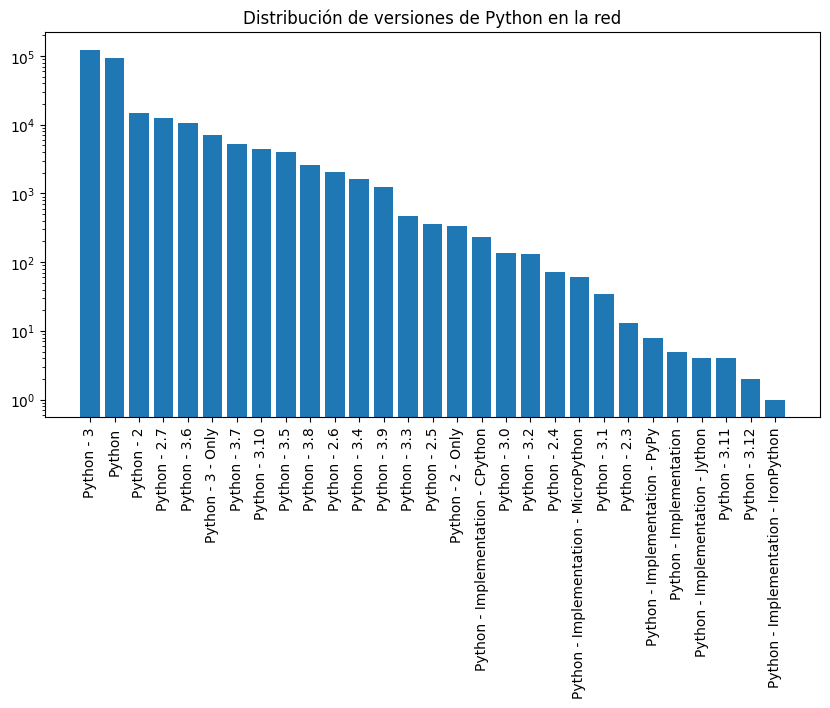

In [59]:
df_grouped = df.groupby("cls Programming Language").count().sort_values("Name", ascending=False).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(df_grouped["cls Programming Language"], df_grouped["Name"])
ax.set_xticklabels(df_grouped["cls Programming Language"], rotation = 90)
ax.set_yscale("log")
ax.set_title("Distribución de versiones de Python en la red")
plt.show()

## Licencias

C:\Users\facuj\AppData\Local\Temp\ipykernel_1432\1107827227.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_grouped["cls License"], rotation = 90)


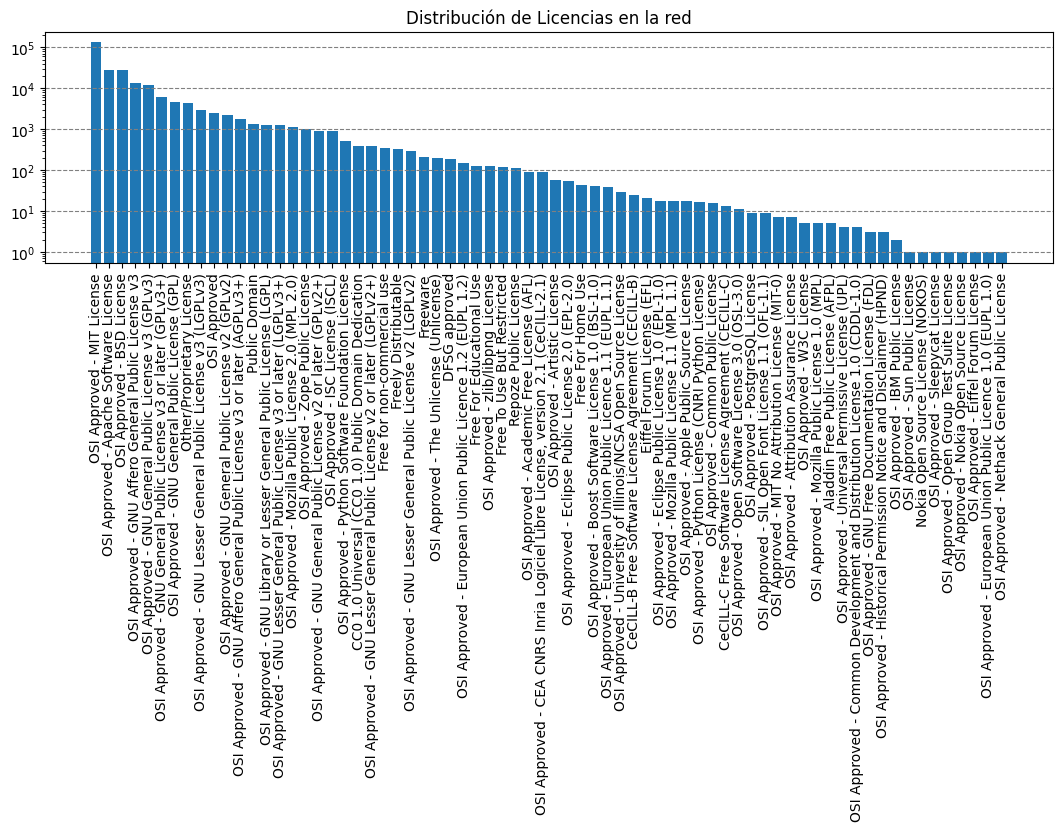

In [62]:
df_grouped = df.groupby("cls License").count().sort_values("Name", ascending=False).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(13, 3))

ax.bar(df_grouped["cls License"], df_grouped["Name"])
ax.set_xticklabels(df_grouped["cls License"], rotation = 90)
ax.set_yscale("log")
ax.set_title("Distribución de Licencias en la red")
ax.grid(axis="y", color="gray", ls="--")
plt.show()

# Tags

In [27]:
tags_series = df["Tags"].replace("", None).dropna()
print(f"Cantidad de paquetes con tags: {len(tags_series)} ({len(tags_series)/len(df)*100:.0f}% del dataset original)")

Cantidad de paquetes con tags: 136235 (34% del dataset original)


Veamos si hay relación entre si tiene tags o no, y la cantidad de dependencias de la librería.

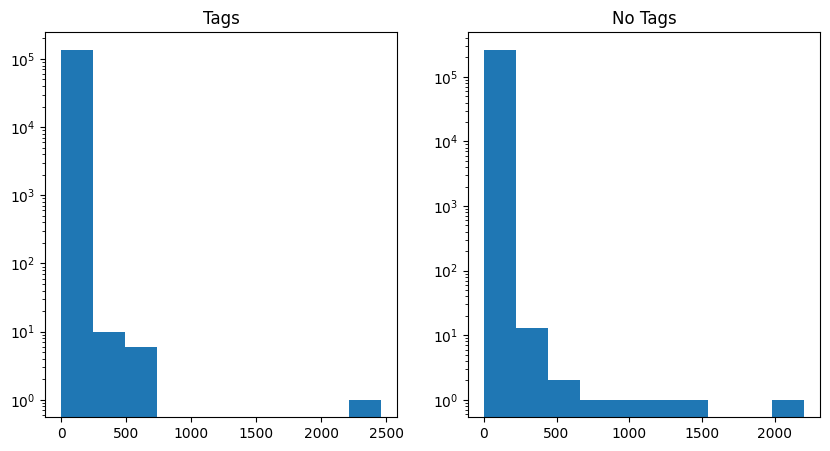

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(df[df["Has Tags"] == True]["Amount Dependencies"])
ax[1].hist(df[df["Has Tags"] == False]["Amount Dependencies"])

ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].set_title("Tags")
ax[1].set_title("No Tags")

plt.show()

Vemos que no hay correlación entre si tiene etiquetas o si no las tiene a la hora de depender de alguien (No hay un bias en las tags por cantidad de librerías que importa). Analogamente podemos hacer el análisis al revés (Ver la distribución de grado).

['api', 'django', 'data', 'web', 'plone', 'cli', 'development', 'testing', 'machine learning', 'json', 'client', 'sdk', 'rest', 'nlp', 'database', 'aws', 'learning', 'jupyter', 'logging', 'test']


C:\Users\facuj\AppData\Local\Temp\ipykernel_12324\1833367118.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags_df.iloc[:20]["Word"], rotation = 90)


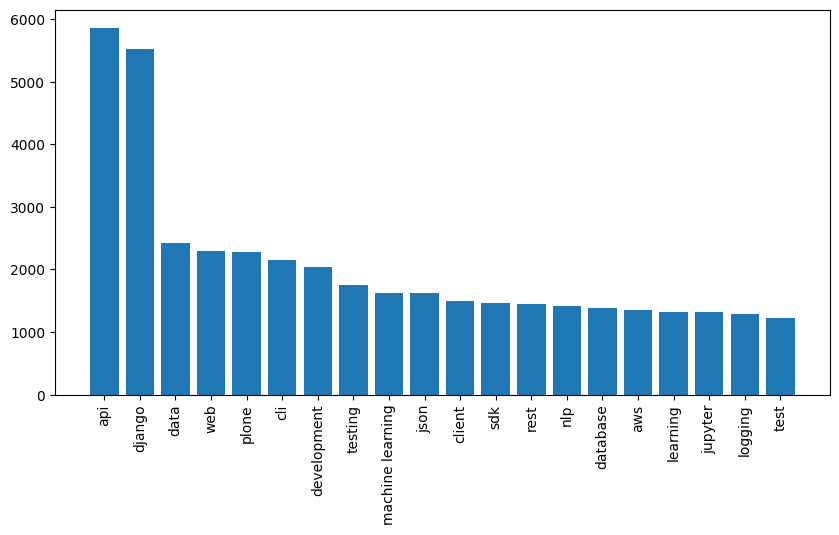

In [65]:
from collections import Counter

def try_remove(tags: str, string: str):
    try:
        tags.remove(string)
    except ValueError:
        pass
    return tags

def parse_tags(tags: str):
    tags = tags.lower()
 
    if "," in tags:
        tags = tags.split(",")
    else:
        tags = tags.split(" ")

    tags = try_remove(tags, " ")
    tags = try_remove(tags, "")
    tags = try_remove(tags, "python")
    tags = try_remove(tags, "pip")

    return tags

tags = tags_series.apply(parse_tags)

cum_tags = []
for t in tags.dropna():
    cum_tags += t

tags_count = sorted(list(dict(Counter(cum_tags)).items()), key=lambda x: x[1], reverse=True)
tags_df = pd.DataFrame(tags_count, columns=["Word", "Count"])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_size = 20
ax.bar(tags_df.iloc[:20]["Word"], tags_df.iloc[:20]["Count"])
ax.set_xticklabels(tags_df.iloc[:20]["Word"], rotation = 90)
print(list(tags_df.iloc[:20]["Word"]))
plt.show()